In [11]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


--2024-02-04 14:21:51--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.207, 172.253.119.207, 108.177.111.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2024-02-04 14:21:51 (192 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [14]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [15]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
625/625 - 9s - loss: 0.6672 - accuracy: 0.5811 - val_loss: 0.5958 - val_accuracy: 0.6986 - 9s/epoch - 15ms/step
Epoch 2/10
625/625 - 3s - loss: 0.4564 - accuracy: 0.8250 - val_loss: 0.3999 - val_accuracy: 0.8310 - 3s/epoch - 5ms/step
Epoch 3/10
625/625 - 2s - loss: 0.3269 - accuracy: 0.8724 - val_loss: 0.3607 - val_accuracy: 0.8492 - 2s/epoch - 4ms/step
Epoch 4/10
625/625 - 2s - loss: 0.2728 - accuracy: 0.8939 - val_loss: 0.3559 - val_accuracy: 0.8462 - 2s/epoch - 4ms/step
Epoch 5/10
625/625 - 2s - loss: 0.2372 - accuracy: 0.9075 - val_loss: 0.3424 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 6/10
625/625 - 3s - loss: 0.2100 - accuracy: 0.9204 - val_loss: 0.3583 - val_accuracy: 0.8466 - 3s/epoch - 4ms/step
Epoch 7/10
625/625 - 2s - loss: 0.1880 - accuracy: 0.9303 - val_loss: 0.3531 - val_accuracy: 0.8544 - 2s/epoch - 4ms/step
Epoch 8/10
625/625 - 2s - loss: 0.1686 - accuracy: 0.9365 - val_loss: 0.3641 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 9/10
625/625 - 2s

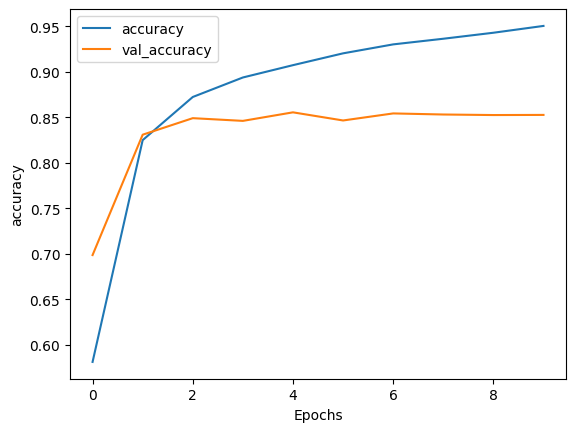

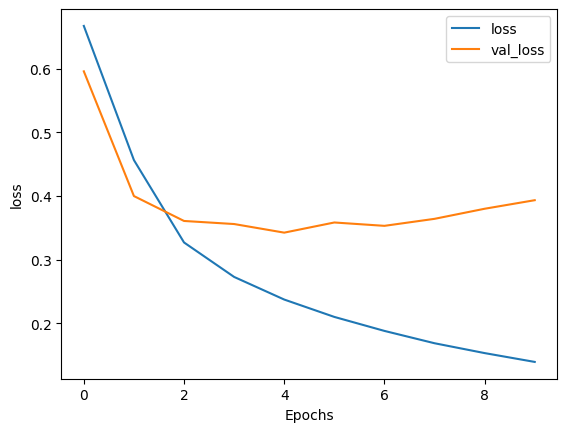

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [29]:
def predict_(string: str):
  res = tokenizer.texts_to_sequences([string])
  res = pad_sequences(res, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return 'Sarcasm' if float(model.predict(res)) > 0.5 else 'Serious'

In [30]:
predict_("granny starting to fear spiders in the garden might be real")

1/1 [==============================] - 0s 19ms/step


'Sarcasm'

In [31]:
predict_("game of thrones season finale showing this sunday night")

1/1 [==============================] - 0s 17ms/step


'Serious'

In [33]:
predict_("Flying horse was found in Ohio")

1/1 [==============================] - 0s 19ms/step


'Serious'

# **Damn, Ohio scares me...**

In [34]:
predict_("Florida Man pissed on the head of cleaner in McDonald's")

1/1 [==============================] - 0s 18ms/step


'Sarcasm'